# Introduction à l'apprentissage automatique par le calcul de régression linéaire

Le calcul d'une droite de régression linéaire est ici l'occasion d'expérimenter des premiers calculs d'apprentissages automatiques (en anglais *machine learning*).

Dans ce texte, nous nous limitons à un recherche à un seul facteur, ici il s'agit de trouver la corrélation entre les loyers d'un appartement et leur surface.

Nous commençons par rappeler la calcul classique des paramètres de la droite de regression linéaire par les outils statistiques. Puis nous montrons la solution utilisant l'algorithme du gradient comme montré sur le blog de Thibault [Miximum](https://www.miximum.fr/blog/premiers-tests-avec-le-machine-learning/). Enfin nous terminons en montrant l'utilisation de l'extension d'apprentissage automatique [SciKit Learn](https://scikit-learn.org/stable/index.html) toujours pour résoudre ce problème.


Dans son blog, Thibault propose comme fichier de données, les loyers des appartements à Montpellier en 1995 en fonction de leur surface. Ce [fichier](loyers_montpellier_2015.csv) a été recopié sur ce répertoire. Il a été obtenu par Thibault sur le site de  [l'observatoire national des loyers](https://www.data.gouv.fr/fr/datasets/resultats-nationaux-des-observatoires-locaux-des-loyers/).

Je lis ce fichier en utilisant l'extension [pandas](https://pandas.pydata.org/).

In [2]:
import pandas as pd
df = pd.read_csv('loyers_montpellier_2015.csv')
df[:5]

,surface,loyer_mensuel
0,25,370
1,25,370
2,26,430
3,26,423
4,26,424


On afficher ces données sous formes d'un nuage de points (voir [ici](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) pour plus d'information). La commande `regplot` de l'extension [seaborn](https://www.geeksforgeeks.org/python-seaborn-regplot-method/) affiche directement le nuage de point et sa droite de régression.

<Axes: xlabel='surface', ylabel='loyer_mensuel'>

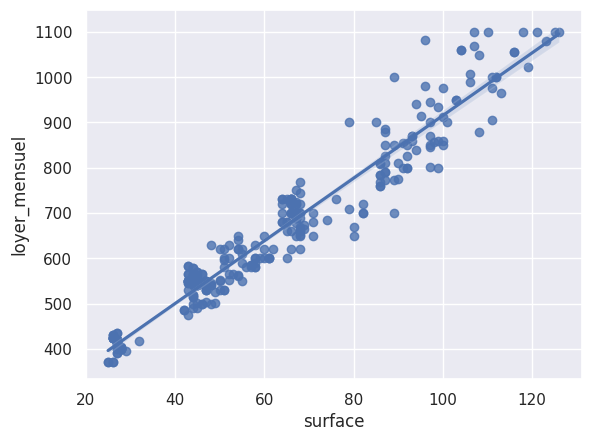

In [3]:
import seaborn as sns

# style seaborn
sns.set_theme(style="darkgrid")

# plt.plot(df['surface'], df['loyer_mensuel'], 'bo')
sns.regplot(x='surface',y='loyer_mensuel', data=df)


Nous allons maintenant recalculer les coefficients de cette droite de régression.

# Résolution en utilisant l'extension `statistics`

Les [calculs théoriques](https://fr.wikipedia.org/wiki/R%C3%A9gression_lin%C3%A9aire) donne l'équation de droite de régression linéaire.

$$ y = \beta_0 + \beta_1 \times x $$

et les coefficients sont donnés par les équations suivantes.

$$
\begin{array}{ll}
\beta_1 & = \text{cov}(X,Y) / \text{var}(X) \\
\beta_0 & = \bar{y} - \beta_1 \times \bar{x} \\
\end{array}
$$

avec la définition usuelle des moyennes ($\bar{y}$, $\bar{y}$), de la covariance et de la variance.

$$
\begin{align*}
&\bar{x}         = \frac{1}{n} \sum_{i=1}^n x_i \\
&\text{var}(X)   = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2 \\
&\text{cov}(X,Y) = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) \\ 
\end{align*}
$$

Heureusement pour nous, l'extension [statistics](https://docs.python.org/3/library/statistics.html) calcule directement ces résultats.

<Axes: xlabel='surface', ylabel='loyer_mensuel'>

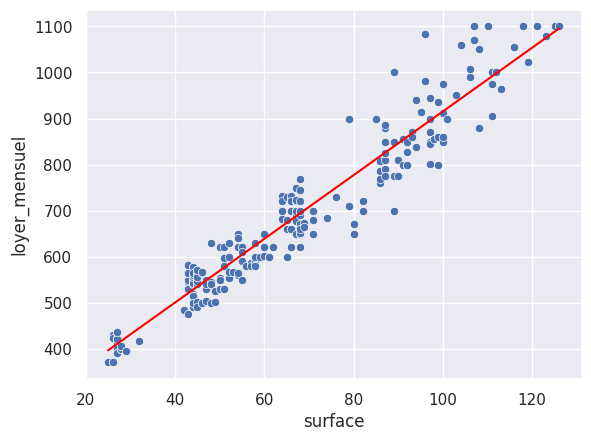

In [5]:
import statistics as stat
import seaborn as sns

# Je converti les séries Pandas en listes pour pouvoir 
# les utilisers dans l'extension 'statistics' pour calculer
# directement les coefficients de régression.
surfaces = df['surface'].tolist()
loyers = df['loyer_mensuel'].tolist()
slope, intercept = stat.linear_regression(surfaces, loyers)

# Je construis ensuite les prédictions de la droite de régression.
predictions = []
for surf in surfaces:
    predictions.append(slope * surf + intercept)
# La boucle sur les éléments de la liste 'surfaces' est obligatoire
# car ces éléments sont du type flottant.

# je définis un style seaborn un peu plus sympa
sns.set_theme(style="darkgrid")

# j'affiche (uniquement) le nuage de points
sns.scatterplot(x=df['surface'], y=df['loyer_mensuel'])

# j'affiche la ligne de régression
sns.lineplot(x=df['surface'],y=predictions, color='red')

# Construire son algorithme du gradient

Le blog de Thibault [Miximum](https://www.miximum.fr/blog/premiers-tests-avec-le-machine-learning/) présente la construction de cet algorithme du gradient. On trouve aussi plus de détails sur cet algorithme sur la page [Wikipedia](https://fr.wikipedia.org/wiki/Algorithme_du_gradient).

Le sujet est toujours de remplacer le nuage de points des données observées par une droite qui permettra de faire ensuite des prévisions. 

$$y = \theta_0 + \theta_1 \times x $$

Le couple $\theta = [\theta_0, \theta_1]$ contient les paramètres à trouver. Pour un couple $\theta$ donné, cette équation sera une hypothèse approchant le résultat cherché et nous allons améliorer cette hypothèse étape par étape. Nous aurons donc une fonction paramétrée par $\theta$.

$$ h_\theta(x) = \theta_0 + \theta_1 \times x$$

En appliquant cette hypothèse aux données observées $[(x_i, y_i)] nous pouvons calculer une erreur globale.

$$ \text{error} = \sum_i \left[ h_\theta(x_i) - y_i \right]^2$$

Cette $\text{error}$ est une fonction de de $\theta$ qu'on notera $J(\theta)$. On note aussi $m$ le nombre de données d'entrée. L'expression de cette fonction $J(\theta_0, \theta_1)$ est alors la suivante.

$$ J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=1}^m \left[ \theta_0 + \theta_1 \times x_i - y_i \right]^2$$

*(Remarquons que nous divisions par $2m$ au lieu de $m$ comme on aurait fait pour une moyenne. Ceci ne change rien au résultat, mais simplifie les calculs plus loin.)*

Pour continuer la résolution, on se place dans un autre espace où les coordonnées ne sont plus $(x,y)$ mais ces deux paramètres $(\theta_0,\theta_1)$. La valeur de $J$ peut alors être représentée par une couleur ou une hauteur sur un troisième axe fictif comme le montre la figure ci-dessous.

![fonction à deux paramètres](./img/RQKM5OWWMA.png)

Le couple de paramètres que nous cherchons $\theta = (\theta_0,\theta_1)$ se trouve au minimum de cette fonction $J$. 

Cette représentation de la valeur de $J$ comme une hauteur sur un troisième axe imaginaire est souvent plus parlante. On imagine marcher sur cette surface en plein brouillard. Pour trouver le fond de cette vallée, nous nous basons sur un pas réguliers : tant que nous descendons, c'est que nous avançons vers le minimum. Si cette descente se ralentie, il est probable que nous approchons de la solution. Si tout d'un coup nous remontons, c'est que nous avons sûrement dépassé ce minimum. C'est en termes imagés le principe de l'algorithme du gradient.

$J$ étant une fonction à deux paramètres, son gradient s'écrit de la manière suivante

$$ \overrightarrow{\nabla J} =\frac{\partial J}{\partial \theta_0} \overrightarrow{u_{\theta_0}} + \frac{\partial J}{\partial \theta_1} \vec{u_{\theta_1}}$$

(Pour d'éventuelles révisions sur la notion de gradient, voir ce [lien](./img/fonctions.pdf))

À chaque pas, il faut choisir une direction de descente et [on montre qu'une solution est de choisir l'inverse du gradient comme direction de descente](https://fr.wikipedia.org/wiki/Direction_de_descente). Si on reprend l'image de notre surface, le gradient est la projection sur la carte de la direction « où cela monte ». Les gradients sont d'ailleurs des vecteurs perpendiculaires aux lignes de niveau. En prenant la direction inverse, on est donc à peu près sûr de descendre, comme le montre l'image ci-dessous.

![chemin](./img/Gradient_descent.png)

En pratique, on multiplie cette direction par un pas, qui représente la vitesse à laquelle on veut descendre. Ce coefficient est aussi à optimiser. Un pas important permet de descendre plus vite, mais peut aussi nous faire manquer le minimum exacte.

En clair, on fera les pas suivants.

$$
\theta_0 \rightarrow \theta_0 - \alpha \times \frac{\partial J}{\partial \theta_0}
\quad ; \quad
\theta_1 \rightarrow \theta_1 - \alpha \times \frac{\partial J}{\partial \theta_1}
$$

La méthode du gradient n'est pas la seule méthode pour trouver la meilleure pente. D'autres méthodes jugées plus efficaces existent comme la [méthode BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS).

Pour éviter aussi les cas particuliers ou les deux paramètres auraient des ordres de grandeur totalement différent, on peut aussi normaliser les données $(x_i)_i$ et $(y_i)_i$. Cela se ferait de la manière suivante.

In [3]:
surfaces = df['surface'].tolist()
surf_min = min(surfaces)
surf_max = max(surfaces)
surf_range = surf_max - surf_min
surf_norm = []
for surf in surfaces:
    surf_norm.append((surf - surf_min) / surf_range)

loyers = df['loyer_mensuel'].tolist()
loy_min = min(loyers)
loy_max = max(loyers)
loy_range = loy_max - loy_min
loy_norm = []
for loy in loyers:
    loy_norm.append((loy - loy_min) / loy_range)

Néanmoins ici les surface et les loyers sont des nombres ayant à peu près le même ordre de grandeur et donc on n'utilisera pas cette normalisation.

Si nous reprenons l'expression exact de $J$ , les pas à effectuer sur $\theta_0$ et $\theta_1$ seront les suivants.

$$


\theta_0 \rightarrow \theta_0 - \alpha \times \frac{1}{m} \sum_{i=1}^m \left[ \theta_0 + \theta_1 \times x_i - y_i \right]
\quad ; \quad
\theta_1 \rightarrow \theta_1 - \alpha \times \frac{1}{m} \sum_{i=1}^m x_i\left[ \theta_0 + \theta_1 \times x_i - y_i \right]
$$


Notre fonction hypothèse, qui est donc ici une droite (mais on pourrait la remplacer par une autre courbe), s'appliquera au paramètres normalisés.

<Axes: xlabel='surface', ylabel='loyer_mensuel'>

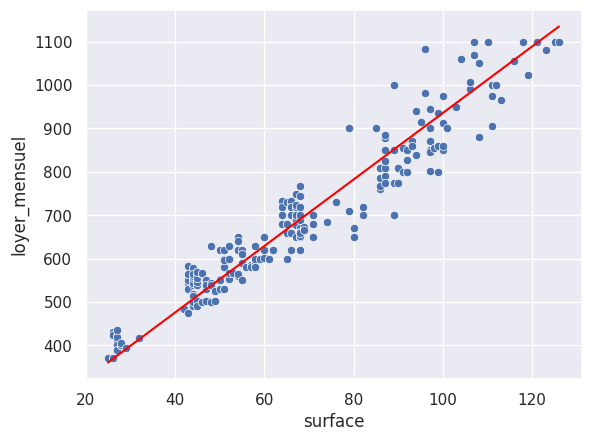

In [7]:
# theta est un tableau qui contient la liste des paramètres θ
def hypothesis(input, theta):
    return theta[0] + theta[1] * input    

def run_gradient_descent(x, y, theta):
    '''
      x est la liste de données d'entrée, les surfaces
      y est la liste des données de sorties, les loyers
      theta contient les paramètres du modèle en construction
    '''
    learning_rate = 0.0001  # c'est le paramètre α
    m = len(y)
    new_theta = theta

    # Mise à jour des paramètres theta à chaque tour
    nb_of_theta = len(theta)
    for t in range(nb_of_theta):
        # calcul des dérivées partielles de la fonction J
        errors = 0
        for i in range(m):
            if t == 0:
                errors += (hypothesis(x[i], theta) - y[i])
            else:
                errors += (hypothesis(x[i], theta) - y[i])*x[i]
        errors /= m

        # Mise à jour du paramètre theta en multipliant le taux
        # d'apprentissage (α) et la dérivée J'
        new_theta[t] = theta[t] - learning_rate * errors
    
    return new_theta

# ici on pourrait initialiser θ aléatoirement, mais je choisis de mettre 0 partout
theta = [0,0]
surfaces = df['surface'].tolist()
loyers = df['loyer_mensuel'].tolist()

NB_ITERATIONS = 100000

for i in range(NB_ITERATIONS):
    theta = run_gradient_descent(surfaces, loyers, theta)

intercept, slope = theta[0], theta[1]

# On construit les prédictions
predictions = []
for surf in surfaces:
    predictions.append(slope * surf + intercept)
# boucles obligatoires car surf est un float

# style seaborn
sns.set_theme(style="darkgrid")

# affichage du nuage de points
sns.scatterplot(x=df['surface'], y=df['loyer_mensuel'])

# affichage de la ligne de régression
sns.lineplot(x=df['surface'],y=predictions, color='red')


Cet algorithme n'est pas optimisé et on peut tester plusieurs valeurs du nombre d'itérations à réaliser. On voit qu'il faut au moins 10000 itérations pour commencer à obtenir une droite de régression correcte.

# Utiliser l'extension `SciKit Learn`



L'extension [SciKit Learn](https://scikit-learn.org/stable/index.html) offre plusieurs applications d'apprentissage automatique, dont la regression linéaire que nous venons de programmer. Mais bien sûr, cette extension est bien plus efficace que le programme que nous avons écrit plus haut. Cette extension possède [un sous module dédié aux regressions linéaires](https://scikit-learn.org/stable/modules/linear_model.html). 

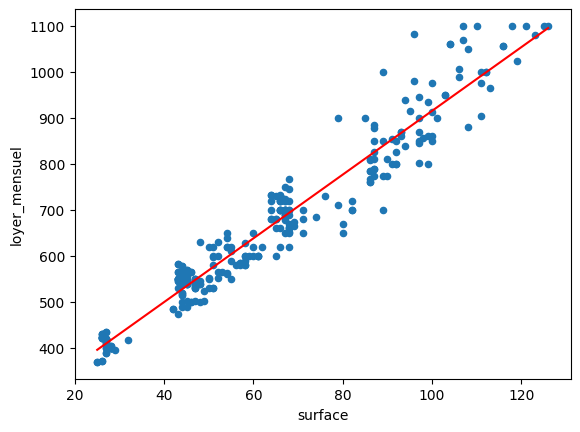

In [16]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(df[['surface']], df['loyer_mensuel'])

ax = df.plot.scatter(x='surface', y='loyer_mensuel', alpha=1)
ax.plot(df['surface'], lin.predict(df[['surface']]),c='red')

# Conclusion

La recherche d'une droite de régression linéaire peut être une première opportunité de tester un algorithme d'apprentissage automatique. L'extension [Scikit learn](https://scikit-learn.org/stable/modules/linear_model.html) montre qu'il y a bien d'autres possibilités.

Notre algorithme « fait maison » nous a aussi ouvert la mécanique interne de l'un de ces algorithmes d'apprentissages automatiques. Comme les autres, il inclue une méthode de recherche d'optimum, qui elle-même fait l'objet de beaucoup d'autres développements à une époque où on ne parlait pas encore d'apprentissage automatique.

